# 1. Importing Dependencies

In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [5]:
tf.config.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 2. Build Data Loading Functions

In [6]:
import gdown
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=fb56761d-dc18-448f-8b16-ce18b1721ea0
To: /content/data.zip
100%|██████████| 423M/423M [00:08<00:00, 51.2MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [7]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [10]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    print("Original path:", path)

    # Corrected file name extraction
    file_name = path.split('/')[-1].split('.')[0]  # For Unix-like paths
    # Alternative for Windows: file_name = path.split('\\')[-1].split('.')[0]


    # Video path
    video_path = os.path.join('data','s1',f'{file_name}.mpg')

    # Alignment path
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')


    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, alignments

In [20]:
test_path = './data/s1/bbal6n.mpg'

In [21]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

''

In [22]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

Original path: ./data/s1/bbal6n.mpg
Extracted file name: bbal6n
Video path: data/s1/bbal6n.mpg
Alignment path: data/alignments/s1/bbal6n.align


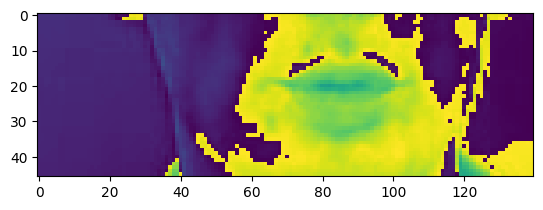

In [23]:
plt.imshow(frames[25])

In [24]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [25]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 3. Creating Data Pipeline

In [26]:
from matplotlib import pyplot as plt

In [27]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [30]:
frames, alignments = data.as_numpy_iterator().next()

Original path: ./data/s1/bgbb1s.mpg
Extracted file name: bgbb1s
Video path: data/s1/bgbb1s.mpg
Alignment path: data/alignments/s1/bgbb1s.align
Original path: ./data/s1/swbo8n.mpg
Extracted file name: swbo8n
Video path: data/s1/swbo8n.mpg
Alignment path: data/alignments/s1/swbo8n.align


In [31]:
len(frames)

2

In [32]:
sample = data.as_numpy_iterator()

In [33]:
val = sample.next(); val[0]

Original path: ./data/s1/pwaj7s.mpg
Extracted file name: pwaj7s
Video path: data/s1/pwaj7s.mpg
Alignment path: data/alignments/s1/pwaj7s.align
Original path: ./data/s1/swiu5s.mpg
Extracted file name: swiu5s
Video path: data/s1/swiu5s.mpg
Alignment path: data/alignments/s1/swiu5s.align
Original path: ./data/s1/srihzn.mpg
Extracted file name: srihzn
Video path: data/s1/srihzn.mpg
Alignment path: data/alignments/s1/srihzn.align


array([[[[[ 1.4695078 ],
          [ 1.4695078 ],
          [ 1.5489407 ],
          ...,
          [ 0.07943285],
          [ 0.07943285],
          [ 0.07943285]],

         [[ 1.4695078 ],
          [ 1.4695078 ],
          [ 1.5489407 ],
          ...,
          [ 0.07943285],
          [ 0.07943285],
          [ 0.07943285]],

         [[ 1.3503585 ],
          [ 1.3503585 ],
          [ 1.3503585 ],
          ...,
          [ 0.07943285],
          [ 0.07943285],
          [ 0.07943285]],

         ...,

         [[ 1.0723435 ],
          [ 1.0326271 ],
          [ 1.0326271 ],
          ...,
          [ 9.88939   ],
          [ 9.88939   ],
          [ 9.88939   ]],

         [[ 1.0326271 ],
          [ 1.0326271 ],
          [ 1.0326271 ],
          ...,
          [ 9.88939   ],
          [ 9.88939   ],
          [ 9.88939   ]],

         [[ 1.0326271 ],
          [ 1.0326271 ],
          [ 1.0326271 ],
          ...,
          [ 9.88939   ],
          [ 9.88939   ],
          

In [34]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

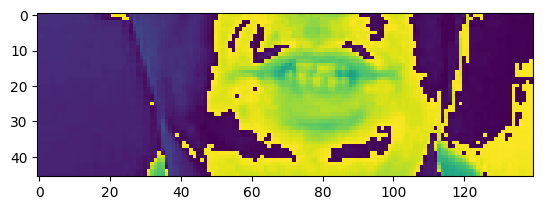

In [35]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [36]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place white at j seven soon'>

# 4. Design the Deep Neural Network

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [38]:
data.as_numpy_iterator().next()[0][0].shape

Original path: ./data/s1/pwwk5s.mpg
Extracted file name: pwwk5s
Video path: data/s1/pwwk5s.mpg
Alignment path: data/alignments/s1/pwwk5s.align
Original path: ./data/s1/sria7s.mpg
Extracted file name: sria7s
Video path: data/s1/sria7s.mpg
Alignment path: data/alignments/s1/sria7s.align
Original path: ./data/s1/bgwb7a.mpg
Extracted file name: bgwb7a
Video path: data/s1/bgwb7a.mpg
Alignment path: data/alignments/s1/bgwb7a.align


(75, 46, 140, 1)

In [39]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [41]:
yhat = model.predict(val[0])

1/1 [==============================] - 18s 18s/step


In [42]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'dddaaaaaaaaaaaaaaaaaaaaaaaaxxxxxxxxxxaaaaggggggggggggaaaggxxxxxxxxxxxbbbbbb'>

In [43]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'dddaaaaaaaaaaaaaaaaaaaaaaaaxxxxxxxxxxaaaaggggggggggggaaaggxxxxxxxxxxxbbbbbb'>

In [44]:
model.input_shape

(None, 75, 46, 140, 1)

In [45]:
model.output_shape

(None, 75, 41)

# 5. Setup Training Options and Train

In [46]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [47]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [48]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [49]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [50]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [51]:
schedule_callback = LearningRateScheduler(scheduler)


In [52]:
example_callback = ProduceExample(test)

In [ ]:
# model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 6. Make a Prediction

In [53]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=13873de9-3a12-4a8d-9caf-e335aef9888a
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:01<00:00, 52.2MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [54]:
model.load_weights('models/checkpoint')

In [55]:
test_data = test.as_numpy_iterator()

In [57]:
sample = test_data.next()

Original path: ./data/s1/bgbn9s.mpg
Extracted file name: bgbn9s
Video path: data/s1/bgbn9s.mpg
Alignment path: data/alignments/s1/bgbn9s.align


In [58]:
yhat = model.predict(sample[0])

1/1 [==============================] - 17s 17s/step


In [59]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by y two now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set red with b eight now'>]

In [60]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [61]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by y two now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set red with b eight now'>]

# Test on a Video

In [62]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

Original path: ./data/s1/bras9a.mpg
Extracted file name: bras9a
Video path: data/s1/bras9a.mpg
Alignment path: data/alignments/s1/bras9a.align


In [63]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [64]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 5s 5s/step


In [65]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [66]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]